In [1]:
using DataFrames, Gadfly
using Vec, LinearAlgebra
using GridWorldPathFollowing

┌ Info: Loading DataFrames support into Gadfly.jl
└ @ Gadfly /home/kylebrown/.julia/packages/Gadfly/09PWZ/src/mapping.jl:228
┌ Info: Recompiling stale cache file /home/kylebrown/.julia/compiled/v1.0/GridWorldPathFollowing/45eed.ji for GridWorldPathFollowing [25f5f308-beb7-11e9-07d3-0b7b1f9adfa7]
└ @ Base loading.jl:1190


In [2]:
function plot_traj_with_steps(traj;Δt=0.01,pad=0.01)
    t_range = get_start_time(traj):Δt:get_end_time(traj)
    plot(
        layer( x=[get_position(traj,t).x for t in t_range], y=[get_position(traj,t).y for t in t_range],
            Geom.path, Theme(default_color="black") ),
        layer( x=[get_start_pt(seg).x for seg in traj.segments], y=[get_start_pt(seg).y for seg in traj.segments],
            size=[8pt], Geom.point, Theme(default_color="red") ),
        layer( x=[get_end_pt(seg).x for seg in traj.segments], y=[get_end_pt(seg).y for seg in traj.segments],
            size=[8pt],Geom.point, Theme(default_color="yellow") ),
        layer( xmin=map(w->w.pt.x - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
            xmax=map(w->w.pt.x + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
            ymin=map(w->w.pt.y - grid_path.cellwidth/2, grid_path.waypoints) .+ pad,
            ymax=map(w->w.pt.y + grid_path.cellwidth/2, grid_path.waypoints) .- pad,
            Geom.rect ),
        Coord.cartesian(fixed=true)
    )
end
function plot_vel_and_yaw_rate(traj;Δt=0.1)
    t_vec = collect(get_start_time(traj):Δt:get_end_time(traj))
    df = DataFrame(
        t=t_vec, 
        theta=[atan(get_heading(traj,t)) for t in t_vec],
        s=[get_dist(traj,t) for t in t_vec], 
        v=[norm(get_vel(traj,t)) for t in t_vec] )
    vstack( plot(df,x="t", y="theta",Geom.path), 
        plot(df,x="t",y="v",Geom.path,Theme(default_color="red")) )
end
function plot_accel_vel_pos(traj,t_vec)
    t = [[get_start_time(seg) for seg in traj.segments]..., get_end_time(traj)]
    cum_d = [0, cumsum([get_length(seg) for seg in traj.segments])...]
    vstack(
        plot(
            layer(x=t_vec[1:end-1],y=accel,Geom.step,Theme(default_color="green")),
            layer(x=t_vec,y=vel,Geom.path,Theme(default_color="red")),
            Guide.manual_color_key("",["accel","vel"],["green","red"])
        ),
        plot(
            layer(x=t_vec,y=pos,Geom.path,Theme(default_color="blue")),
            layer(x = t,y = cum_d,Geom.step,Theme(default_color="black")),
            Guide.manual_color_key("",["pos"],["blue"])
        )
    )
end

plot_accel_vel_pos (generic function with 1 method)

In [3]:
start_pt = VecE2(0.0,0.0)
start_time = 0.0
action_sequence = [DOWN,RIGHT,WAIT,UP,RIGHT,WAIT,WAIT,RIGHT,RIGHT,DOWN,DOWN,LEFT,UP,LEFT,DOWN,LEFT,LEFT]
# action_sequence = [RIGHT,WAIT,UP,RIGHT]
cell_width = 1.0
transition_time = 2.0
grid_path = construct_grid_world_path(start_pt,start_time,
    action_sequence,cell_width,transition_time)

traj = construct_trajectory(grid_path)
verify(traj)

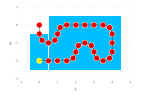

In [4]:
plot_traj_with_steps(traj)

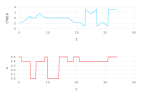

In [5]:
plot_vel_and_yaw_rate(traj)

# Optimize Velocity Profile
We apply a polynomial acceleration command in each time window

In [31]:
t_vec, accel, vel, pos = optimize_velocity_profile(traj;a_max=1.25);

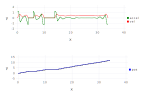

In [32]:
plot_accel_vel_pos(traj,t_vec)

# Closed-loop tracking of Trajectory with optimized speed profile

In [26]:
dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos);

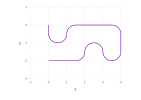

In [27]:
sim_model = UnicycleModel()
controller = TrackingController(k0=4.0,k1=4.0)
t0 = 0.0
tf = get_end_time(dense_traj)
dt = 0.05
state_pt = get_trajectory_point_by_time(dense_traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] - 0.01*rand(3)
states, cmds = simulate(sim_model,controller,dense_traj,initial_state,t0,tf,dt)

time_vec = collect(t0:dt:tf)
errors = Vector{Float64}()
for (t,state) in zip(time_vec,states)
    target_pt = get_trajectory_point_by_time(dense_traj, t)
    target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
    push!(errors, norm(target[1:2] - state[1:2]))
end

plot(
    layer( x=[s[1] for s in states], y=[s[2] for s in states], Geom.path,Theme(default_color="blue")),
    layer( x=[get_position(dense_traj,t).x for t in time_vec], y=[get_position(dense_traj,t).y for t in time_vec],
        Geom.path,Theme(default_color="red") ),
    Coord.Cartesian(fixed=true)
)

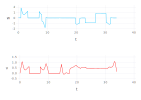

In [28]:
df = DataFrame(t=time_vec[1:end-1],v=[u[2] for u in cmds],w=[u[1] for u in cmds])
vstack(
    plot(df,x="t",y="w",Geom.path),
    plot(df,x="t",y="v",Geom.path,Theme(default_color="red"))
)

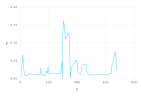

In [29]:
plot( x=collect(1:length(errors)), y=errors, Geom.path )

# Optimize controller params

In [33]:
function optimize_controller_params(sim_model,traj,initial_state;
        dt=0.1,
        k0_range=1.0:0.25:4.0,
        k1_range=1.0:0.25:4.0
    )
    t0 = get_start_time(traj)
    tf = get_end_time(traj)

    opt_vec = [NaN,NaN]
    opt_cost = Inf
    for k0 in k0_range
        for k1 in k1_range
            controller = TrackingController(k0=k0,k1=k1)
            states, cmds = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)
            err = 0.0
            for (t,state) in zip(collect(t0:dt:tf),states)
                target_pt = get_trajectory_point_by_time(traj, t)
                target = [target_pt.pos.x, target_pt.pos.y, atan(target_pt.heading)]
                err += norm(target[1:2] - state[1:2])^2
            end
            if err < opt_cost
                opt_vec = [k0,k1]
            end
        end
    end
    opt_vec
end

optimize_controller_params (generic function with 1 method)

In [34]:
state_pt = get_trajectory_point_by_time(dense_traj, t0)
initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] - 0.01*rand(3)
optimize_controller_params(sim_model,dense_traj,initial_state)

2-element Array{Float64,1}:
 4.0
 4.0

In [ ]:
# function GridWorldPathFollowing.get_action(controller::TrackingController,target,ff,state,t)
#     a = controller.a   # 0 < a < vmax - sup_{t >= 0} abs(vr)
#     k0 = controller.k0 # k0 > 0
#     μ = controller.μ   # μ = 0 or 1
#     γ = controller.γ   # 0 < γ < 1
#     ϵ = controller.ϵ   # 0 < ϵ < 1/(1+γ)
#     k1 = controller.k1 # k1 > 0
#     b = controller.b   # b > 0
#     # state (global frame)
#     x,y,θ = state[1],state[2],state[3]
#     # reference (global frame)
#     xr,yr,θr = target[1],target[2],target[3]
#     wr,vr = ff[1],ff[2]
# #     if abs(vr) <= 0.000001 # dirty trick to avoid problems with waiting
# #         return [0.0,0.0]
# #     end
#     # errors in robot frame
#     e = [ cos(θ) sin(θ) 0;
#          -sin(θ) cos(θ) 0;
#               0      0  1]*[xr-x,yr-y,get_angular_offset(θ,θr)]
#     xe,ye,θe = e[1],e[2],e[3]
#     # change of coordinates
#     x0 = θe
#     x1 = ye
#     x2 = -xe
#     # u0 = wr - w
#     # u1 = v - vr*cos(x0)
#     V1 = x1^2 + x2^2
#     u1 = -sat(k0*x2,a)
#     h = 1 + γ*cos(μ*t)
#     h_dot = -μ*γ*sin(μ*t)
#     x0_ = x0 + ϵ*h*x1 / (1 + V1^(1/2))
#     α = 1 - ϵ*h*x2 / (1 + V1^(1/2))
#     β = ϵ*(
#         (h_dot*x1+h*wr*x2+h*vr*sin(x0))/(1 + V1^(1/2))
#         - (h*x1/( ((1 + V1^(1/2))^2)*V1^(1/2) ))
#         * (x1*vr*sin(x0) - sat(k0*x2,a)*x2)
#     )
#     u0 = -β/α - sat(k1*x0_,b)
#     # transform back
#     w = -u0 + wr
#     v = u1 + vr*cos(x0)
#     return [w, v]
# end

In [ ]:
# c = VecE2(0.0,0.0)
# r = 0.0
# θ1 = 0.0
# w = 1.0
# dt = 1.0
# T = 4
# traj = Trajectory([ConstSpeedArcTrajectory(c,r,θ1+w*(t-1)*dt,w*dt,TimeInterval(dt*(t-1),dt*t)) for t in 1:T])
# verify(traj)

# t_vec = collect(0.0:0.01:T)
# accel = zeros(length(t_vec)-1)
# vel = zeros(length(t_vec))
# pos = zeros(length(t_vec))
# dense_traj = DenseTrajectory(traj,t_vec,accel,vel,pos)
# verify(dense_traj)

In [ ]:
# sim_model = UnicycleModel()
# controller = TrackingController(μ=0.01)
# t0 = 0.0
# tf = get_end_time(traj)
# dt = 0.1
# state_pt = get_trajectory_point_by_time(traj, t0)
# initial_state = [state_pt.pos.x, state_pt.pos.y, atan(state_pt.heading)] - 0.01*rand(3)
# states = simulate(sim_model,controller,traj,initial_state,t0,tf,dt)

# t_vec = collect(t0:dt:tf)
# plot(
#     layer( x=[s[1] for s in states], y=[s[2] for s in states], Geom.path,Theme(default_color="blue")),
#     layer( x=[get_position(dense_traj,t).x for t in t_vec], y=[get_position(dense_traj,t).y for t in t_vec],
#         Geom.point,Theme(default_color="red") ),
#     Coord.Cartesian(fixed=true)
# )

In [ ]:
# function linear_interp(v,t)
#     idx = find_index_in_sorted_array(v,t)-1
#     idx = max(1, min(length(v)-1, idx))
#     # if length(v) > 0 && idx >= length(v)
#     #     idx = length(v)-1
#     # elseif idx == 0
#     #     idx += 1
#     # end
#     Δt = (t - v[idx]) / (v[idx+1] - v[idx])
#     return idx, Δt
# end